In [1]:
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

import os
import torch
from plyfile import PlyData, PlyElement

In [2]:
torch.__version__

'1.6.0'

In [3]:
mesh = trimesh.load_mesh('./dataset/torus/train/Torus.102.ply')

In [4]:
mesh.bounds

array([[-5.31809092, -2.08288884, -3.5826776 ],
       [ 1.81348979,  5.81034184,  2.14478397]])

In [5]:
files = os.listdir('dataset')
for f in files:
    l = os.listdir(os.path.join('dataset',f,'test'))
    print(f,len(l))

cube 50
cone 50
cylinder 50
uv_sphere 50
plane 50
torus 170


In [6]:
def plot_points(mesh):
    x = []
    y = []
    z = []
    if isinstance(mesh,np.ndarray):
        x = mesh.T[0]
        y = mesh.T[1]
        z = mesh.T[2]
    else:
        for m in mesh.vertices:
            x.append(m[0])
            y.append(m[1])
            z.append(m[2])
        x = np.array(x)
        y = np.array(y)
        z = np.array(z)
    fig = plt.figure(figsize=(10, 10))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.scatter3D(x[0], z[0], -y[0], c = 'red')
    ax.scatter3D(0,0,0, c='green')

    ax.view_init(100, 20)
    plt.show()
    

In [62]:
path_to_model = './dataset/torus/train/Torus.102.ply'
mesh = PlyData.read(path_to_model)
# dir(mesh)

NameError: name 'PlyData' is not defined

In [32]:
mesh['face'].data

array([], dtype=[('vertex_indices', 'O')])

In [33]:
# Trimesh bunny .obj model

bunny_trimesh = trimesh.load(path_to_model)

if isinstance(bunny_trimesh, trimesh.Scene):
    bunny_trimesh = bunny_trimesh.dump(concatenate=True)

bunny_trimesh.vertices -= bunny_trimesh.center_mass
scaling = 2 / bunny_trimesh.scale
bunny_trimesh.apply_scale(scaling=scaling)

# Rainbow bunny in trimesh
# for facet in bunny_trimesh.facets:
#   bunny_trimesh.visual.face_colors[facet] = trimesh.visual.random_color() 

# Bunny mesh in pytorch3d
verts, faces_idx, _ = load_obj(path_to_model)
faces = faces_idx.verts_idx

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)

# Rainbow bunny in pytorch3d
# verts_rgb = torch.rand_like(verts)[None]

textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a Meshes object for the bunny.
bunny_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

AttributeError: 'PointCloud' object has no attribute 'center_mass'

In [7]:
m_dir = 'dataset/cone/train/'
files = os.listdir(m_dir)
print(len(files))
meshes = []
for f in files:
    mesh = trimesh.load_mesh(m_dir + f)
    t = torch.tensor(mesh.vertices)
#     print(t.min(), t.max(), t.mean())
    meshes+=[mesh]

100


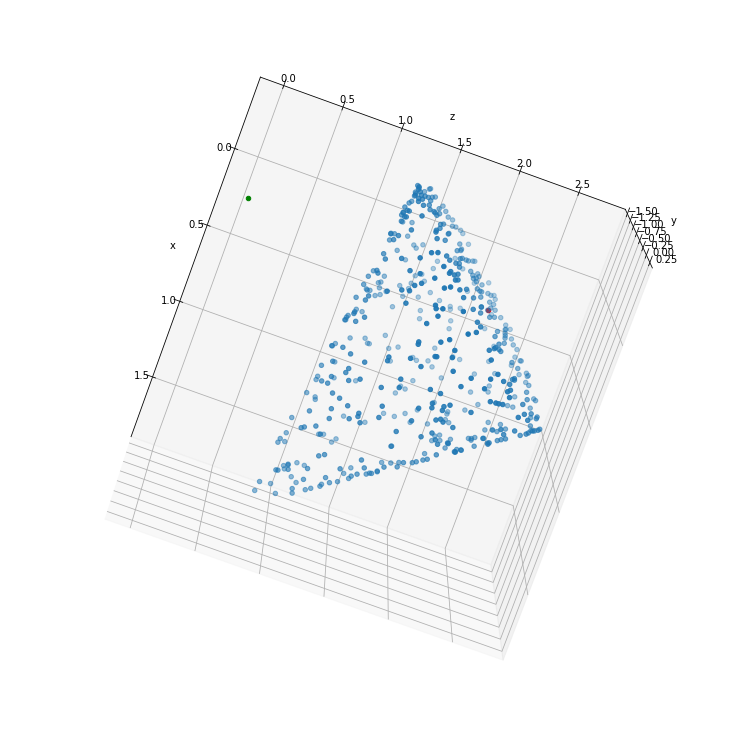

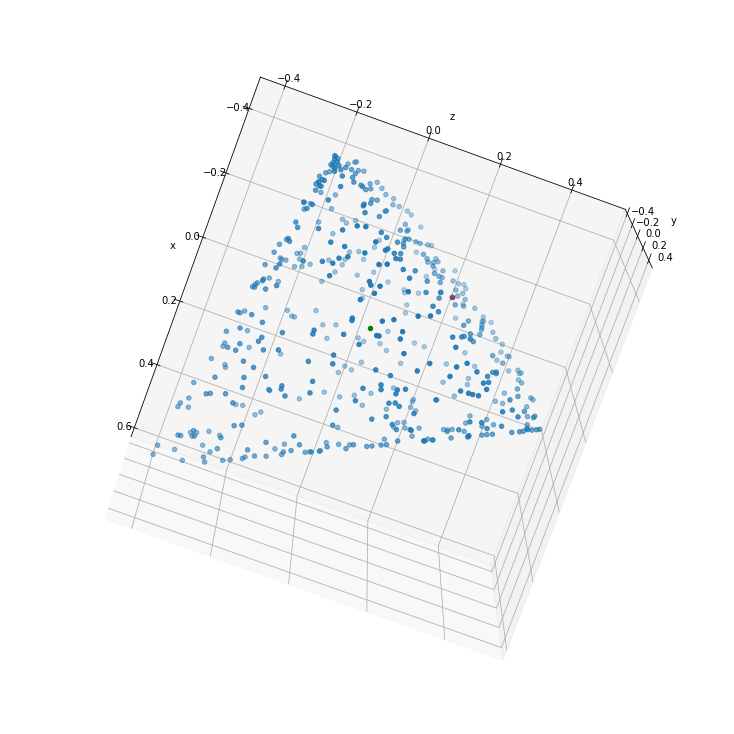

In [8]:
meshe = mesh = trimesh.load_mesh(m_dir + files[11])
plot_points(meshe)
points = np.array(meshe.vertices)
mean = points.mean(axis=0)
points = points - np.expand_dims(mean,0)
scale  = (points**2).sum(axis=1).max()
points = points/scale
# vertices = vertices/2
plot_points(points)

In [9]:
import os
import torch
from model import PointNetCls
from dataloader import points_dataloader
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim

Количество примеров:  920   920
torch.Size([10, 500])


In [10]:
loss = nn.NLLLoss()

In [11]:
pred = torch.tensor([[-1,-0.1, -0.1, 0]])
target = torch.tensor([[0,1,0,1]])

In [12]:
m(torch.tensor([0.,1,2]))

NameError: name 'm' is not defined

In [13]:
inpt = torch.randn(2, 5)

In [14]:
inpt[0][0] = 20
# inpt[0][1] = torch.exp(torch.tensor(1.))
m = nn.LogSoftmax()
m(inpt)

/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


tensor([[  0.0000, -19.6312, -20.5054, -19.4748, -19.9651],
        [ -2.0976,  -2.6676,  -0.6333,  -2.4569,  -1.6539]])

In [15]:

# target is LongTensor for index of true class for each item in batch
# each element in target has to have 0 <= value < C
target = torch.tensor([0, 0])

# output is tensor of 0 dimension, i.e., scaler wrapped in tensor
output = loss(m(inpt), target)
output

/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


tensor(1.0488)

In [16]:
from dataloader import points_dataloader
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score
from model import PointNetCls, PointNetDenseCls

In [17]:
data = points_dataloader('dataset', True)
loader = DataLoader(data,2)
it = iter(loader)

Количество примеров:  920   920


In [18]:
model = PointNetDenseCls(6)
i = next(it)
x = i['inpt']
l = i['label']
y = model(x)[0]
print(y.view(-1,6).shape,l.shape)


torch.Size([1000, 6]) torch.Size([2, 500])


In [19]:
d = torch.load('model.pt')
model = PointNetCls(6)
model.load_state_dict(d)

<All keys matched successfully>

In [20]:
def accuracy(dataloader, model):
    y_pred = []
    y_true = []
    for i in dataloader:
        inpt = i['inpt']
        labels = i['label']
        predict = model(inpt)[0]
        argmax = predict.argmax(axis=1).detach().cpu().tolist()
        y_pred = y_pred + argmax
        y_true = y_true + labels.detach().cpu().tolist()
    return accuracy_score(y_true, y_pred)

In [21]:
accuracy(loader, model)

KeyboardInterrupt: 

In [573]:
a = classification_report(y_pred, y_true)
print(a)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       1.00      0.40      0.58       420
           5       0.00      0.00      0.00         0

    accuracy                           0.40       420
   macro avg       0.17      0.07      0.10       420
weighted avg       1.00      0.40      0.58       420



In [570]:
(np.array(y_true) == ).sum()

0

In [19]:
choice = np.random.choice(102,5, replace=True)
choice

a = np.expand_dims(choice,0)  # center
a.shape

(1, 5)

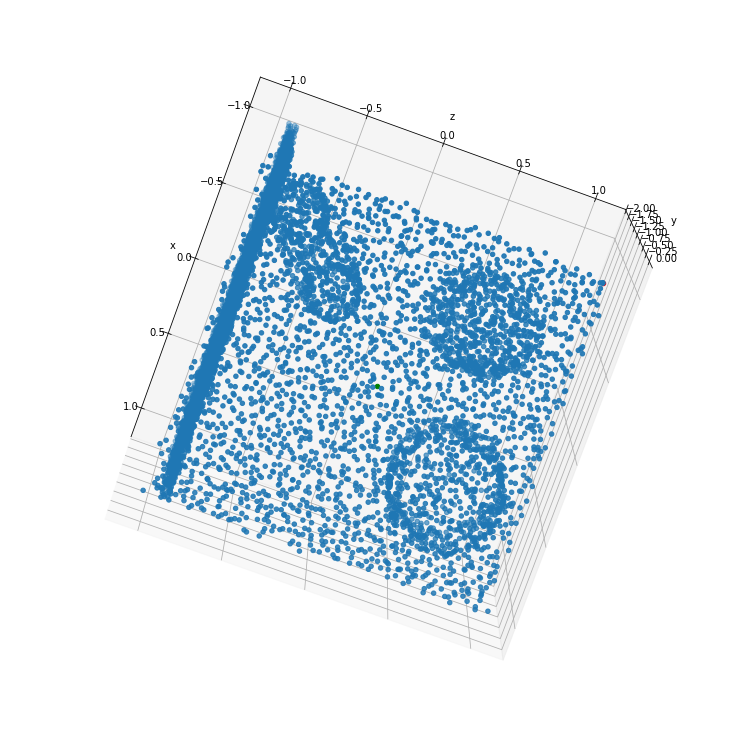

In [69]:
points = trimesh.load_mesh('scene.ply')
plot_points(points)

In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
from dataloader import points_dataloader
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score
from model import PointNetCls, PointNetDenseCls

dir_path = 'dataset new/'
test_data = points_dataloader(dir_path, False, True)
test_loader = DataLoader(test_data, 5)

Количество примеров:  420   420


In [8]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F


class STN3d(nn.Module):
    def __init__(self):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.array([1,0,0,0,1,0,0,0,1]).astype(np.float32))).view(1,9).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x


class STNkd(nn.Module):
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.k = k

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1,self.k*self.k).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

class PointNetfeat(nn.Module):
    def __init__(self, global_feat = True, feature_transform = False):
        super(PointNetfeat, self).__init__()
        self.stn = STN3d()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.global_feat = global_feat
        self.feature_transform = feature_transform
        if self.feature_transform:
            self.fstn = STNkd(k=64)

    def forward(self, x):
        n_pts = x.size()[2]
        trans = self.stn(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))

        if self.feature_transform:
            trans_feat = self.fstn(x)
            x = x.transpose(2,1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2,1)
        else:
            trans_feat = None

        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans, trans_feat
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, n_pts)
            return torch.cat([x, pointfeat], 1), trans, trans_feat

class PointNetCls(nn.Module):
    def __init__(self, k=2, feature_transform=True):
        super(PointNetCls, self).__init__()
        self.feature_transform = feature_transform
        self.feat = PointNetfeat(global_feat=True, feature_transform=feature_transform)
        #Классификатор------------------
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        #------------------------------
        self.dropout = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1), trans, trans_feat


class PointNetDenseCls(nn.Module):
    def __init__(self, k = 2, feature_transform=False):
        super(PointNetDenseCls, self).__init__()
        self.k = k
        self.feature_transform=feature_transform
        self.feat = PointNetfeat(global_feat=False, feature_transform=feature_transform)
        self.conv1 = torch.nn.Conv1d(1088, 512, 1)
        self.conv2 = torch.nn.Conv1d(512, 256, 1)
        self.conv3 = torch.nn.Conv1d(256, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, self.k, 1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, x):
        batchsize = x.size()[0]
        n_pts = x.size()[2]
        x, trans, trans_feat = self.feat(x)
        print('f ',x.shape, trans.shape)
        x = F.relu(self.bn1(self.conv1(x)))
        print('1 ',x.shape)
        x = F.relu(self.bn2(self.conv2(x)))
        print('2 ',x.shape)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        print('4 ',x.shape)
        x = x.transpose(2,1).contiguous()
        print('t ', x.shape)
        x = F.log_softmax(x.view(-1,self.k), dim=-1)
        print(x.shape)
        x = x.view(batchsize, n_pts, self.k)
        print('o ',x.shape)
        return x, trans, trans_feat


In [9]:
i = next(iter(test_loader))
i['inpt'].shape

torch.Size([5, 3, 500])

In [33]:
model = PointNetCls(6)
out = model(i['inpt'])

In [141]:
len(test_loader)

84

In [148]:
for k, inpt in enumerate(test_loader):
    i = inpt['inpt']
    t = inpt['label']
    if k> 15:
        break

tensor([[[ 0.0695, -0.1907, -0.2488,  ...,  0.3594, -0.2022,  0.1117],
         [ 0.1829, -0.2798, -0.0683,  ...,  0.1723, -0.2395,  0.0033],
         [-0.1111, -0.1997,  0.2861,  ...,  0.0737, -0.0451,  0.1754]],

        [[ 0.3364, -0.0096,  0.1185,  ..., -0.1562, -0.3345, -0.2432],
         [ 0.1736,  0.0041, -0.0120,  ...,  0.1508, -0.0887,  0.1549],
         [-0.0062,  0.3568,  0.2702,  ...,  0.2438, -0.1852, -0.0273]],

        [[-0.0939,  0.1280, -0.1345,  ...,  0.3034,  0.1439, -0.4060],
         [-0.1201, -0.0632,  0.1065,  ..., -0.1902,  0.0164, -0.0364],
         [-0.2319, -0.2906, -0.2361,  ...,  0.2691,  0.1834, -0.1582]],

        [[-0.3083, -0.1776, -0.1166,  ...,  0.1023, -0.0480, -0.3625],
         [ 0.1964,  0.4596,  0.1883,  ...,  0.0057, -0.1525, -0.1527],
         [-0.2396, -0.1255, -0.2772,  ...,  0.2872,  0.1321, -0.2472]],

        [[ 0.1165, -0.1926, -0.3726,  ...,  0.0941,  0.2835, -0.0756],
         [ 0.4191,  0.0845,  0.0526,  ...,  0.0504, -0.1399, -0.3514]

In [143]:
model = model.eval()
i.shape

torch.Size([5, 3, 500])

In [145]:
o = model(i)[0]
print(o)
o.argmax(axis=1)

tensor([[ -8.6160,  -2.3495,  -6.8150, -14.2364,  -0.1017, -12.7354],
        [-18.2071,  -0.0379,  -3.5358, -19.8600,  -4.9467,  -6.9742],
        [ -2.5871,  -0.9380,  -1.8838,  -3.2058,  -1.4136,  -2.3271],
        [ -2.2540,  -0.7809,  -2.1748,  -3.3890,  -2.3297,  -1.6486],
        [ -4.1986,  -0.6728,  -1.8211,  -4.2165,  -1.2366,  -4.8631]],
       grad_fn=<LogSoftmaxBackward>)


tensor([4, 1, 1, 1, 1])

tensor([[[ 0.0695, -0.1907, -0.2488,  ...,  0.3594, -0.2022,  0.1117],
         [ 0.1829, -0.2798, -0.0683,  ...,  0.1723, -0.2395,  0.0033],
         [-0.1111, -0.1997,  0.2861,  ...,  0.0737, -0.0451,  0.1754]],

        [[ 0.3364, -0.0096,  0.1185,  ..., -0.1562, -0.3345, -0.2432],
         [ 0.1736,  0.0041, -0.0120,  ...,  0.1508, -0.0887,  0.1549],
         [-0.0062,  0.3568,  0.2702,  ...,  0.2438, -0.1852, -0.0273]],

        [[-0.0939,  0.1280, -0.1345,  ...,  0.3034,  0.1439, -0.4060],
         [-0.1201, -0.0632,  0.1065,  ..., -0.1902,  0.0164, -0.0364],
         [-0.2319, -0.2906, -0.2361,  ...,  0.2691,  0.1834, -0.1582]],

        [[-0.3083, -0.1776, -0.1166,  ...,  0.1023, -0.0480, -0.3625],
         [ 0.1964,  0.4596,  0.1883,  ...,  0.0057, -0.1525, -0.1527],
         [-0.2396, -0.1255, -0.2772,  ...,  0.2872,  0.1321, -0.2472]],

        [[ 0.1165, -0.1926, -0.3726,  ...,  0.0941,  0.2835, -0.0756],
         [ 0.4191,  0.0845,  0.0526,  ...,  0.0504, -0.1399, -0.3514]